# Session 10


## Packages

In [144]:
import tensorflow as tf
import tensorflow_probability as tfp

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import RMSprop

import numpy as np
import os
import matplotlib.pyplot as plt

tfd = tfp.distributions
tfpl = tfp.layers

plt.rcParams['figure.figsize'] = (10, 6)

In [145]:
print("Tensorflow Version: ", tf.__version__)
print("Tensorflow Probability Version: ", tfp.__version__)

Tensorflow Version:  2.18.0
Tensorflow Probability Version:  0.25.0


![MNIST and MNIST-corrupted overview image](https://github.com/goodboychan/goodboychan.github.io/blob/main/_notebooks/image/mnist_corrupted.png?raw=1)

# The MNIST and MNIST-C datasets

In this notebook, you will use the [MNIST](http://yann.lecun.com/exdb/mnist/) and [MNIST-C](https://github.com/google-research/mnist-c) datasets, which both consist of a training set of 60,000 handwritten digits with corresponding labels, and a test set of 10,000 images. The images have been normalised and centred. The MNIST-C dataset is a corrupted version of the MNIST dataset, to test out-of-distribution robustness of computer vision models.

- Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. "Gradient-based learning applied to document recognition." Proceedings of the IEEE, 86(11):2278-2324, November 1998.
- N. Mu and J. Gilmeer. "MNIST-C: A Robustness Benchmark for Computer Vision" https://arxiv.org/abs/1906.02337

Our goal is to construct a neural network that classifies images of handwritten digits into one of 10 classes.

### Load the datasets

We'll start by importing two datasets. The first is the MNIST dataset of handwritten digits, and the second is the MNIST-C dataset, which is a corrupted version of the MNIST dataset. This dataset is available on [TensorFlow datasets](https://www.tensorflow.org/datasets/catalog/mnist_corrupted). We'll be using the dataset with "spatters". We will load and inspect the datasets below. We'll use the notation `_c` to denote `corrupted`. The images are the same as in the original MNIST, but are "corrupted" by some grey spatters.

In [146]:
#@title
!mkdir MNIST
!mkdir MNIST_corrupted

A subdirectory or file MNIST already exists.
A subdirectory or file MNIST_corrupted already exists.


In [147]:
#@title
import requests
r2=requests.get("https://github.com/goodboychan/goodboychan.github.io/raw/main/_notebooks/dataset/MNIST/x_train.npy")
f = open('MNIST/x_train.npy', 'wb')
f.write(r2.content)
f.close()

r2=requests.get("https://github.com/goodboychan/goodboychan.github.io/raw/main/_notebooks/dataset/MNIST/y_train.npy")
f = open('MNIST/y_train.npy', 'wb')
f.write(r2.content)
f.close()

r2=requests.get("https://github.com/goodboychan/goodboychan.github.io/raw/main/_notebooks/dataset/MNIST/x_test.npy")
f = open('MNIST/x_test.npy', 'wb')
f.write(r2.content)
f.close()

r2=requests.get("https://github.com/goodboychan/goodboychan.github.io/raw/main/_notebooks/dataset/MNIST/y_test.npy")
f = open('MNIST/y_test.npy', 'wb')
f.write(r2.content)
f.close()

In [148]:
#@title
r2=requests.get("https://github.com/goodboychan/goodboychan.github.io/raw/main/_notebooks/dataset/MNIST_corrupted/x_train.npy")
f = open('MNIST_corrupted/x_train.npy', 'wb')
f.write(r2.content)
f.close()

r2=requests.get("https://github.com/goodboychan/goodboychan.github.io/raw/main/_notebooks/dataset/MNIST_corrupted/y_train.npy")
f = open('MNIST_corrupted/y_train.npy', 'wb')
f.write(r2.content)
f.close()

r2=requests.get("https://github.com/goodboychan/goodboychan.github.io/raw/main/_notebooks/dataset/MNIST_corrupted/x_test.npy")
f = open('MNIST_corrupted/x_test.npy', 'wb')
f.write(r2.content)
f.close()

r2=requests.get("https://github.com/goodboychan/goodboychan.github.io/raw/main/_notebooks/dataset/MNIST_corrupted/y_test.npy")
f = open('MNIST_corrupted/y_test.npy', 'wb')
f.write(r2.content)
f.close()

In [149]:
#@title
# Function to load training and testing data, with labels in integer and one-hot form

def load_data(name):
    data_dir = name
    x_train = 1 - np.load(os.path.join(data_dir, 'x_train.npy')) / 255.
    x_train = x_train.astype(np.float32)
    y_train = np.load(os.path.join(data_dir, 'y_train.npy'))
    y_train_oh = tf.keras.utils.to_categorical(y_train)
    x_test  = 1 - np.load(os.path.join(data_dir, 'x_test.npy')) / 255.
    x_test = x_test.astype(np.float32)
    y_test  = np.load(os.path.join(data_dir, 'y_test.npy'))
    y_test_oh = tf.keras.utils.to_categorical(y_test)

    return (x_train, y_train, y_train_oh), (x_test, y_test, y_test_oh)

In [150]:
#@title
# Function to inspect dataset digits

def inspect_images(data, num_images):
    fig, ax = plt.subplots(nrows=1, ncols=num_images, figsize=(2*num_images, 2))
    for i in range(num_images):
        ax[i].imshow(data[i, ..., 0], cmap='gray')
        ax[i].axis('off')
    plt.show()

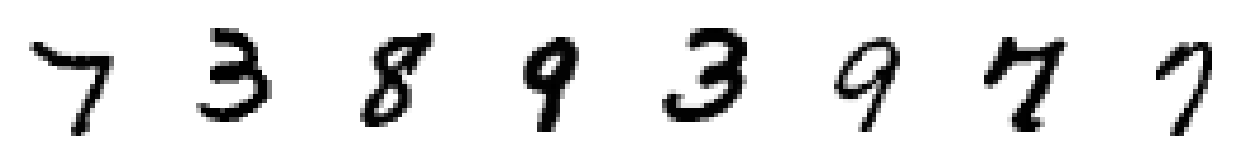

In [151]:
# Load and inspect the MNIST dataset
(x_train, y_train, y_train_oh), (x_test, y_test, y_test_oh) = load_data('MNIST')
inspect_images(data=x_train, num_images=8)

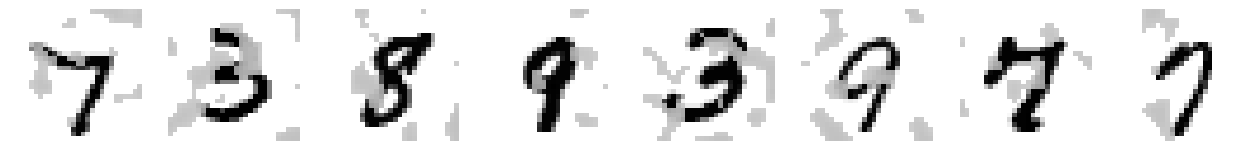

In [152]:
# Load and inspect the MNIST-C dataset
(x_c_train, y_c_train, y_c_train_oh), (x_c_test, y_c_test, y_c_test_oh) = load_data('MNIST_corrupted')
inspect_images(data=x_c_train, num_images=8)

# Neural Networks as Probabilistic Models


The **softmax activation function** is widely used in machine learning, especially in multi-class classification tasks. Its primary purpose is to convert a vector of raw scores (often called logits) into probabilities, where the sum of the probabilities is 1.

### Definition

For a vector $\mathbf{z} = [z_1, z_2, \ldots, z_K]$ of $K$ real-valued logits, the softmax function computes the probability of each class \(i\) as:

$$
\text{softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^K e^{z_j}}
$$

Here:
- $e^{z_i}$ is the exponential of the $i$-th element of the vector.
- $\sum_{j=1}^K e^{z_j}$ is the sum of the exponentials of all elements in the vector.

### Properties
1. **Normalization**: The output is a probability distribution; all probabilities are non-negative, and their sum equals 1:
   $$
   \sum_{i=1}^K \text{softmax}(z_i) = 1.
   $$

2. **Amplification of Differences**: The exponential function amplifies larger logits, making higher scores more dominant in the resulting probability distribution. This property helps in focusing the model's confidence on a single class.

3. **Continuous and Differentiable**: Softmax is smooth, which is essential for gradient-based optimization methods like stochastic gradient descent.

### Intuition
- If all elements of \(\mathbf{z}\) are equal, the softmax function assigns equal probability to each class.
- If one element of \(\mathbf{z}\) is significantly larger than the others, the corresponding probability will be close to 1, while others will be near 0.

### Applications
1. **Output Layer for Classification**:
   - In multi-class classification, the softmax function is used in the final layer of a neural network to model the probability distribution over \(K\) possible classes.
   - The predicted class is the one with the highest softmax probability.

2. **Loss Function**:
   - It is often paired with the categorical cross-entropy loss to optimize classification tasks. Cross-entropy measures how close the predicted probability distribution is to the true distribution (one-hot encoded labels).

### Example
Suppose you have three logits: \([2.0, 1.0, 0.1]\).

1. Compute exponentials:
   $$
   e^{2.0} \approx 7.39, \quad e^{1.0} \approx 2.72, \quad e^{0.1} \approx 1.11
   $$

2. Compute the sum:
   $$
   7.39 + 2.72 + 1.11 = 11.22
   $$

3. Compute softmax probabilities:
   $$
   \text{softmax}(2.0) = \frac{7.39}{11.22} \approx 0.658, \quad
   \text{softmax}(1.0) = \frac{2.72}{11.22} \approx 0.242, \quad
   \text{softmax}(0.1) = \frac{1.11}{11.22} \approx 0.099
   $$

### Insights
- The class corresponding to \(z = 2.0\) has the highest probability (65.8%), indicating the model's confidence in that class.
- Small changes in the logits can lead to non-linear changes in the softmax probabilities, making it sensitive to the relative differences between scores.


In [153]:

tf.random.set_seed(0)

cnn_model = Sequential([
        Conv2D(kernel_size=(5, 5), filters=8, activation='relu', padding='VALID', input_shape=(28, 28, 1)),
        MaxPooling2D(pool_size=(6, 6)),
        Flatten(),
        #Adding SoftMax Layer makes the output a probability distribution
        Dense(units=10, activation='softmax')
    ])

# Compile
cnn_model.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])


c:\Users\nickl\Documents\MI\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 24, 24, 8)      │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 4, 4, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,498 (5.85 KB)

 Trainable params: 1,498 (5.85 KB)

 Non-trainable params: 0 (0.00 B)

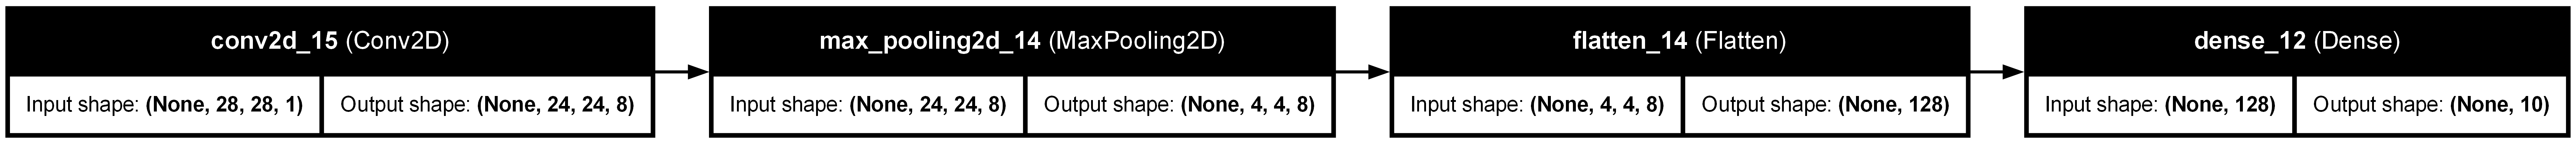

In [154]:
# Print the model summary

cnn_model.summary()

tf.keras.utils.plot_model(
    cnn_model, to_file='model10.png', show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='LR', expand_nested=True, dpi=300,
)

In [155]:
# Train the model

cnn_model.fit(x_train, y_train, epochs=5, validation_split=0.2, shuffle=True)

Epoch 1/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7021 - loss: 1.0604 - val_accuracy: 0.9468 - val_loss: 0.1810
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9536 - loss: 0.1620 - val_accuracy: 0.9603 - val_loss: 0.1248
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9646 - loss: 0.1165 - val_accuracy: 0.9670 - val_loss: 0.1042
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9702 - loss: 0.0970 - val_accuracy: 0.9699 - val_loss: 0.0939
Epoch 5/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9731 - loss: 0.0857 - val_accuracy: 0.9722 - val_loss: 0.0879


In [156]:
# Evaluate the model

print('Accuracy on MNIST test set: ',
      str(cnn_model.evaluate(x_test, y_test, verbose=False)[1]))
print('Accuracy on corrupted MNIST test set: ',
      str(cnn_model.evaluate(x_c_test, y_c_test, verbose=False)[1]))

Accuracy on MNIST test set:  0.9761999845504761
Accuracy on corrupted MNIST test set:  0.9498000144958496


As you might expect, the pointwise performance on the corrupted MNIST set is worse. This makes sense, since this dataset is slightly different, and noisier, than the uncorrupted version. Furthermore, the model was trained on the uncorrupted MNIST data, so has no experience with the spatters.

## Analyse the model predictions

We will now do some deeper analysis by looking at the probabilities the model assigns to each class instead of its single prediction.

The function below will be useful to help us analyse the probabilistic model predictions.

In [157]:
#@title
# Function to make plots of the probabilities that the model estimates for an image

def analyse_model_prediction(data, true_labels, model, image_num, run_ensemble=False):
    if run_ensemble:
        ensemble_size = 200
    else:
        ensemble_size = 1
    image = data[image_num]
    true_label = true_labels[image_num, 0]
    predicted_probabilities = np.empty(shape=(ensemble_size, 10))
    for i in range(ensemble_size):
        predicted_probabilities[i] = model(image[np.newaxis, :]).numpy()[0]
    model_prediction = model(image[np.newaxis, :])
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 2),
                                   gridspec_kw={'width_ratios': [2, 4]})

    # Show the image and the true label
    ax1.imshow(image[..., 0], cmap='gray')
    ax1.axis('off')
    ax1.set_title('True label: {}'.format(str(true_label)))

    # Show a 95% prediction interval of model predicted probabilities
    pct_2p5 = np.array([np.percentile(predicted_probabilities[:, i], 2.5) for i in range(10)])
    pct_97p5 = np.array([np.percentile(predicted_probabilities[:, i], 97.5) for i in range(10)])
    bar = ax2.bar(np.arange(10), pct_97p5, color='red')
    bar[int(true_label)].set_color('green')
    ax2.bar(np.arange(10), pct_2p5-0.02, color='white', linewidth=1, edgecolor='white')
    ax2.set_xticks(np.arange(10))
    ax2.set_ylim([0, 1])
    ax2.set_ylabel('Probability')
    ax2.set_xlabel(f'Model Prediction: {np.argmax(model_prediction)}')
    ax2.set_title('Model estimated probabilities')
    plt.show()

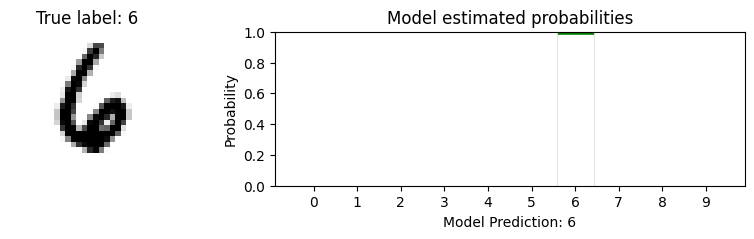

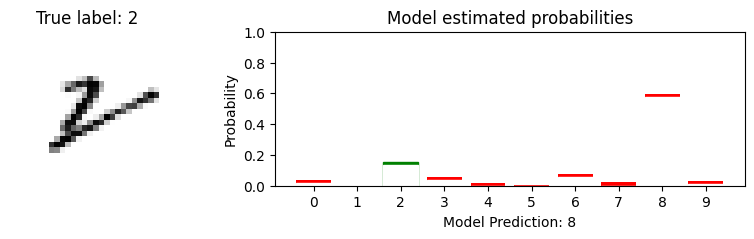

In [158]:
# Prediction examples on MNIST

for i in [0, 1577]:
    analyse_model_prediction(x_test, y_test, cnn_model, i)

The model is very confident that the first image is a 6, which is correct. For the second image, the model struggles, assigning nonzero probabilities to many different classes.

Run the code below to do the same for 2 images from the corrupted MNIST test set.

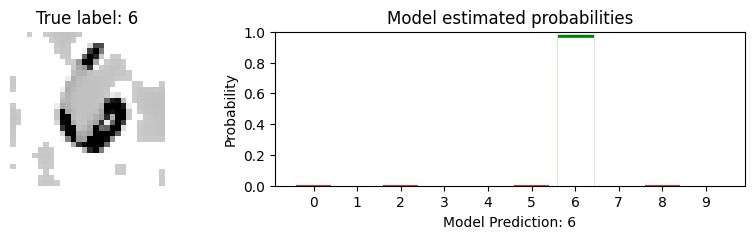

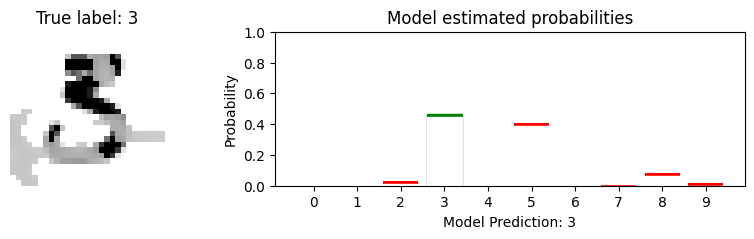

In [159]:
# Prediction examples on MNIST-C

for i in [0, 3702]:
    analyse_model_prediction(x_c_test, y_c_test, cnn_model, i)

The first is the same 6 as you saw above, but the second image is different. Notice how the model can still say with high certainty that the first image is a 6, but struggles for the second.

Finally, have a look at an image for which the model is very sure on MNIST data but very unsure on corrupted MNIST data:

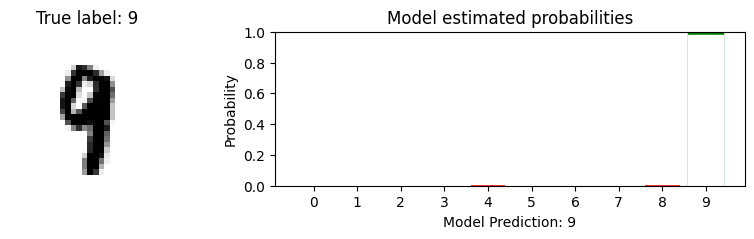

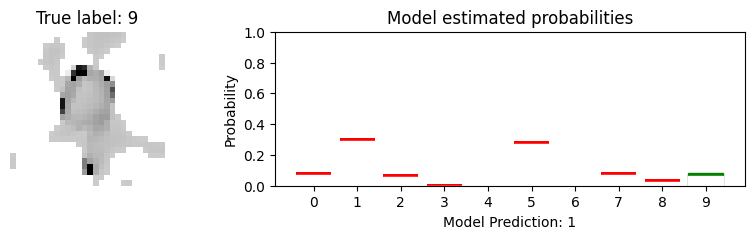

In [179]:
# Prediction examples from both datasets

for i in [9241]:
    analyse_model_prediction(x_test, y_test, cnn_model, i)
    analyse_model_prediction(x_c_test, y_c_test, cnn_model, i)

It's not surprising what's happening here: the spatters cover up most of the number. You would hope a model indicates that it's unsure here, since there's very little information to go by. This is exactly what's happened.

### Exercise 1: Investigating Model Uncertainty in Digit Classification


1. **Identify Uncertain Predictions**:
   - Using a test dataset of digit images, identify cases where the model is **highly uncertain** about its prediction.
   - Specifically, find examples where the top two predicted probabilities are close to each other (e.g., both >30% but <70%), indicating that the model is indecisive between two classes.

2. **Explore Digit id "988"**:
   - Examine the specific case of the digit image labeled with ID "988" in the dataset.
   - Answer the following questions:
     - What does the probability distribution output by the model look like for this digit?
     - Do you think the uncertainty reported by the model reflects the inherent ambiguity of the image? Why or why not?
   - Visualize the digit and provide a short explanation for your answer.
   - Find Digits with similar issues.



## Uncertainty quantification using entropy

We can also make some analysis of the model's uncertainty across the full test set, instead of for individual values. One way to do this is to calculate the [entropy](https://en.wikipedia.org/wiki/Entropy_%28information_theory%29) of the distribution. The entropy is the expected information (or informally, the expected 'surprise') of a random variable, and is a measure of the uncertainty of the random variable. The entropy of the estimated probabilities for sample $i$ is defined as

$$
H_i = -\sum_{j=1}^{10} p_{ij} \text{log}_{2}(p_{ij})
$$

where $p_{ij}$ is the probability that the model assigns to sample $i$ corresponding to label $j$. The entropy as above is measured in _bits_. If the natural logarithm is used instead, the entropy is measured in _nats_.

The key point is that the higher the value, the more unsure the model is.

In [161]:
def compute_entropy(x, labels, model, i):
    probs = model(x).numpy()
    entropy = -np.sum(probs * np.log2(probs), axis=1)
    return entropy[i]

<>:4: SyntaxWarning: invalid escape sequence '\^'
<>:4: SyntaxWarning: invalid escape sequence '\^'
C:\Users\nickl\AppData\Local\Temp\ipykernel_140388\3894222904.py:4: SyntaxWarning: invalid escape sequence '\^'
  print(f"2\^Entropy: {2**compute_entropy(x_c_test, y_c_test, cnn_model, i)}")


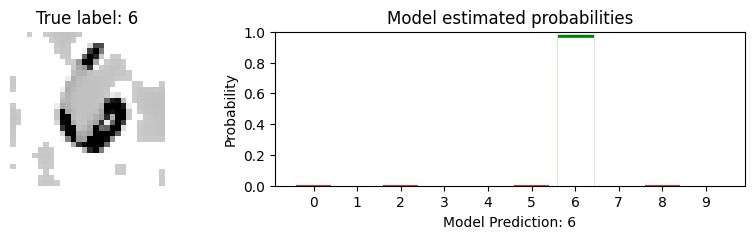

Entropy: 0.19050635397434235
2\^Entropy: 1.141164168912557


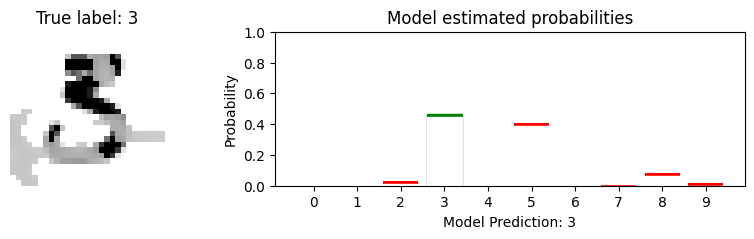

Entropy: 1.6095079183578491
2\^Entropy: 3.0514774272110565


In [162]:
for i in [0, 3702]:
    analyse_model_prediction(x_c_test, y_c_test, cnn_model, i)
    print(f"Entropy: {compute_entropy(x_c_test, y_c_test, cnn_model, i)}")
    print(f"2\^Entropy: {2**compute_entropy(x_c_test, y_c_test, cnn_model, i)}")

### Exercise2 : Exploring Entropy as a Measure of Prediction Uncertainty

- Examine predictions for various digits and observe how the **entropy** reflects the level of uncertainty in the model's predictions. Use examples where the model is confident (low entropy) and uncertain (high entropy) to solidify your understanding.

- Develop an intuition for how \(2^{\text{Entropy}}\) approximates the **effective number of classes** over which the model's probabilities are distributed. Explore cases where the probabilities are concentrated on a few classes versus spread across many.

### Models are more unsure when they are wrong

Let's see the distribution of the entropy of the model's predictions across the MNIST and corrupted MNIST test sets. The plots will be split between predictions the model gets correct and incorrect.

In [163]:
#@title
# Functions to plot the distribution of the information entropy across samples,
# split into whether the model prediction is correct or incorrect


def get_correct_indices(model, x, labels):
    y_model = model(x)
    correct = np.argmax(y_model, axis=1) == np.squeeze(labels)
    correct_indices = [i for i in range(x.shape[0]) if correct[i]]
    incorrect_indices = [i for i in range(x.shape[0]) if not correct[i]]
    return correct_indices, incorrect_indices


def plot_entropy_distribution(model, x, labels):
    probs = model(x).numpy()
    entropy = -np.sum(probs * np.log2(probs), axis=1)
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    for i, category in zip(range(2), ['Correct', 'Incorrect']):
        entropy_category = entropy[get_correct_indices(model, x, labels)[i]]
        mean_entropy = np.mean(entropy_category)
        num_samples = entropy_category.shape[0]
        title = category + 'ly labelled ({:.1f}% of total)'.format(num_samples / x.shape[0] * 100)
        axes[i].hist(entropy_category, weights=(1/num_samples)*np.ones(num_samples))
        axes[i].annotate('Mean: {:.3f} bits'.format(mean_entropy), (0.4, 0.9), ha='center')
        axes[i].set_xlabel('Entropy (bits)')
        axes[i].set_ylim([0, 1])
        axes[i].set_ylabel('Probability')
        axes[i].set_title(title)
    plt.show()

MNIST test set:


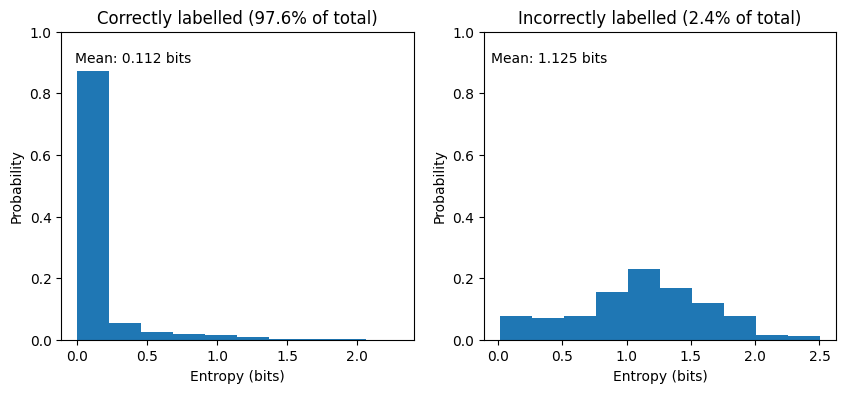

In [164]:
# Entropy plots for the MNIST dataset

print('MNIST test set:')
plot_entropy_distribution(cnn_model, x_test, y_test)

Corrupted MNIST test set:


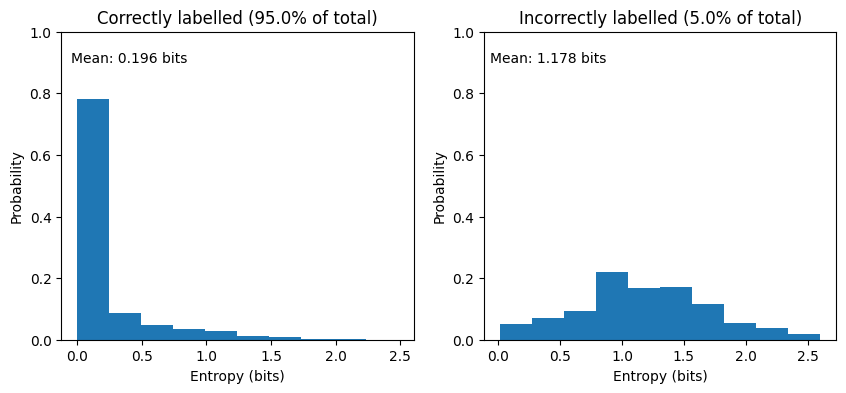

In [165]:
# Entropy plots for the MNIST-C dataset

print('Corrupted MNIST test set:')
plot_entropy_distribution(cnn_model, x_c_test, y_c_test)

There are two main conclusions:
- The model is more unsure on the predictions it got wrong: this means it "knows" when the prediction may be wrong.
- The model is more unsure for the corrupted MNIST test than for the uncorrupted version. Futhermore, this is more pronounced for correct predictions than for those it labels incorrectly.

In this way, the model seems to "know" when it is unsure. This is a great property to have in a machine learning model, and is one of the advantages of probabilistic modelling.


## Using a Probabilistic Model for Selective Predictions

When using a **probabilistic model** to make predictions, the model provides not only a predicted class but also a measure of its confidence (e.g., a probability or uncertainty score). This confidence can help decide when to make a prediction and when to refrain due to uncertainty.

#### Selective Prediction
In situations where the model's uncertainty is high, it might be better to avoid making a prediction rather than risking an incorrect one. This approach is particularly useful in critical applications, such as medical diagnosis or autonomous systems, where incorrect decisions can have serious consequences.

The user can set a **confidence threshold**:
- If the model's confidence for a prediction is above the threshold, the prediction is accepted.
- If the confidence is below the threshold, the model "abstains" from making a prediction.

This process ensures that predictions are made only when the model is sufficiently confident.

#### Coverage
"Coverage" refers to the **fraction of instances** for which the model makes predictions after applying the threshold. For example:
- If the model is applied to 1,000 data points and makes predictions for 800 of them (abstaining on 200 due to low confidence), the coverage is:
  \[
  \text{Coverage} = \frac{\text{Number of predictions made}}{\text{Total number of instances}} = \frac{800}{1000} = 80\%
  \]

#### Accuracy Over Covered Instances
After applying the threshold, you can compute the **accuracy** over the instances where the model did make predictions. This is often referred to as the **selective accuracy** or the accuracy over covered instances.

Selective accuracy is a useful measure because it shows how well the model performs when it is allowed to "choose its battles" by abstaining from uncertain predictions. In general:
- Higher thresholds (more stringent confidence requirements) lead to fewer predictions (lower coverage) but usually higher selective accuracy.
- Lower thresholds result in more predictions (higher coverage) but potentially lower selective accuracy.

#### Key Trade-Off
There is an important trade-off between **coverage** and **accuracy**:
- If you want high coverage (making predictions on almost all instances), you might sacrifice accuracy, as the model will include uncertain cases.
- If you prioritize accuracy, coverage will decrease because the model abstains more frequently.

This trade-off depends on the application and the cost of incorrect predictions versus the cost of abstaining.

#### Example in Practice
Suppose a medical diagnostic model assigns probabilities to different diseases for patients. The user sets a threshold of 90% confidence. For patients where the model predicts with less than 90% confidence, it abstains, asking for a human doctor's review instead. Over the cases where predictions are made, the accuracy of these predictions is calculated.

By using this approach, you can ensure that the model is only relied upon when its predictions are trustworthy, enhancing its utility in real-world scenarios.

In [166]:
#@title
def accuracy_by_threshold(model, x, labels, threshold):
  probs=model(x).numpy()
  above_threshold = np.max(probs,axis=1)>threshold
  correct = np.argmax(probs, axis=1) == np.squeeze(labels)
  return threshold, 100*np.sum(np.logical_and(above_threshold, correct))/np.sum(above_threshold), 100*np.sum(above_threshold)/x.shape[0]

def plot_accuracy_by_threshold(model, x, labels):
  values = np.array([accuracy_by_threshold(model, x, labels, threshold) for threshold in np.arange(0.0,1,0.01)])
  fig, ax1 = plt.subplots()
  ax2 = ax1.twinx()
  ax1.plot(values[:,0],values[:,1], 'g-')
  ax2.plot(values[:,0],values[:,2], 'b-')

  ax1.set_xlabel('Decision Threshold')
  ax1.set_ylabel('Accuracy', color='g')
  ax2.set_ylabel('Coverage', color='b')

  plt.show()

  return np.mean(values[:,1]), np.mean(values[:,2])


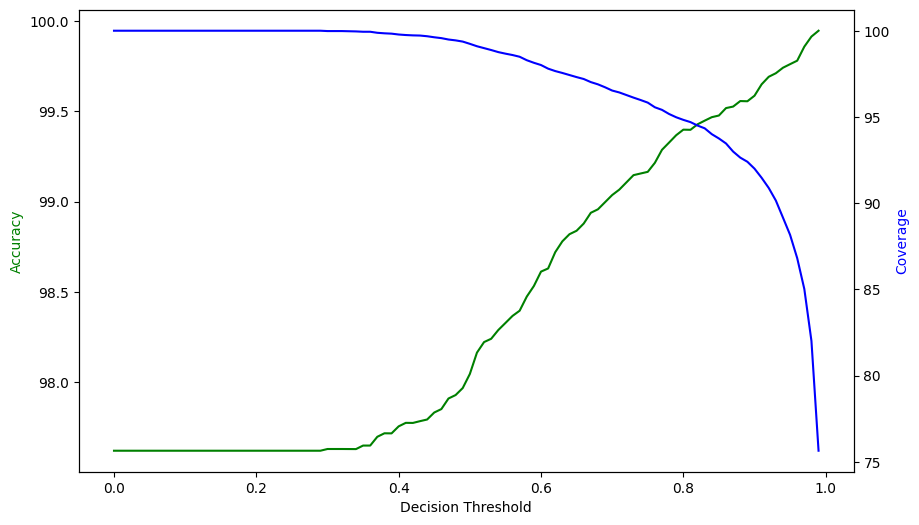

Area under Accuracy on MNIST test set:  98.39072321030764
Area under Coverage on MNIST test set:  97.23380000000002


In [167]:
# MNIST:  Plot Accuracy / Coverage evolution for different thresholds
area_acc, area_coverage = plot_accuracy_by_threshold(cnn_model, x_test, y_test)
print('Area under Accuracy on MNIST test set: ',
      str(area_acc))
print('Area under Coverage on MNIST test set: ',
      str(area_coverage))

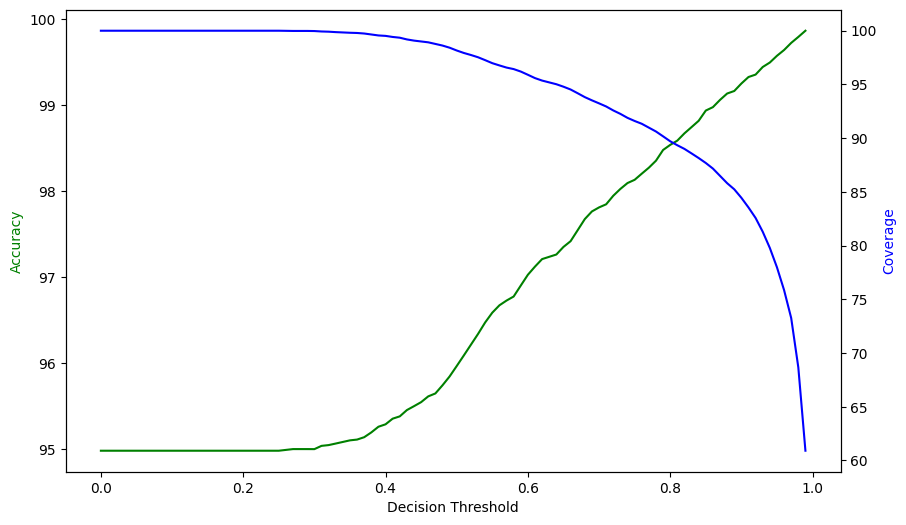

Area under Accuracy on corrupted MNIST test set:  96.59560372545002
Area under Coverage on corrupted MNIST test set:  94.7089


In [168]:
# MNIST-C:  Plot Accuracy / Coverage evolution for different thresholds
area_acc, area_coverage = plot_accuracy_by_threshold(cnn_model, x_c_test, y_c_test)
print('Area under Accuracy on corrupted MNIST test set: ',
      str(area_acc))
print('Area under Coverage on corrupted MNIST test set: ',
      str(area_coverage))


### Exercise 3: Threshold Selection for Desired Accuracy

A user of your machine learning model specifies that their application requires a minimum **accuracy of 99%** for predictions. Your task is to determine the **threshold** for confidence predictions that ensures this accuracy, and compute the resulting **coverage** (the fraction of instances for which the model makes predictions).

#### Instructions:

1. Use the provided function:
   ```python
   _, accuracy, coverage = accuracy_by_threshold(cnn_model, input, labels, threshold)
   ```
   to compute the accuracy and coverage for different thresholds.

2. Perform the computations on:
   - The **MNIST dataset**.
   - The **Corrupted MNIST dataset**.

#### Questions:
1. What threshold ensures at least 99% accuracy for the MNIST dataset? What is the corresponding coverage?
2. What threshold ensures at least 99% accuracy for the Corrupted MNIST dataset? What is the corresponding coverage?

This exercise will help you understand how to adjust a probabilistic model to meet user-defined accuracy requirements and analyze the impact of data quality on coverage.

In [169]:
def find_threshold_for_accuracy(model, x, labels, target_accuracy=99.0):
    for threshold in np.arange(0.0, 1.0, 0.01):
        _, accuracy, coverage = accuracy_by_threshold(model, x, labels, threshold)
        if accuracy >= target_accuracy:
            return threshold, accuracy, coverage
    return None, None, None

# Find threshold for MNIST dataset
mnist_threshold, mnist_accuracy, mnist_coverage = find_threshold_for_accuracy(cnn_model, x_test, y_test)
print(f"MNIST dataset: Threshold = {mnist_threshold}, Accuracy = {mnist_accuracy}%, Coverage = {mnist_coverage}%")

# Find threshold for Corrupted MNIST dataset
corrupted_mnist_threshold, corrupted_mnist_accuracy, corrupted_mnist_coverage = find_threshold_for_accuracy(cnn_model, x_c_test, y_c_test)
print(f"Corrupted MNIST dataset: Threshold = {corrupted_mnist_threshold}, Accuracy = {corrupted_mnist_accuracy}%, Coverage = {corrupted_mnist_coverage}%")

MNIST dataset: Threshold = 0.7000000000000001, Accuracy = 99.03656894229773%, Coverage = 96.53%
Corrupted MNIST dataset: Threshold = 0.87, Accuracy = 99.06347554630594%, Coverage = 86.49%


# Ensemble of CNN models


An **ensemble of neural networks** is a method that combines the predictions of multiple individual models to improve overall performance and robustness. Each neural network in the ensemble independently predicts a probability vector (via the softmax activation function) for a given input. These probability vectors represent the model's confidence for each class.

The final ensemble prediction is obtained by **averaging the probability distributions** produced by all individual models. Mathematically, for an ensemble of \(N\) models, the final predicted probability for class \(c\) is:

$$
P_{\text{ensemble}}(c) = \frac{1}{N} \sum_{i=1}^N P_{\text{model}_i}(c)
$$

where $P_{\text{model}_i}(c)$ is the probability assigned to class \(c\) by the \(i\)-th model.

**Key Points**:
1. **Reduced Variance**: Averaging smooths out the noise from individual models, leading to more stable and reliable predictions.
2. **Improved Generalization**: By leveraging the diversity of individual models (e.g., trained with different initializations or subsets of data), the ensemble typically outperforms any single model.
3. **Interpretation**: The final averaged probability distribution reflects a consensus among all the models, providing a robust measure of confidence in the predictions.

In [170]:
# Let us create an esemble of CNNs models.
ENSEMBLE_SIZE=2

ensemble_cnns = []

for i in range(ENSEMBLE_SIZE):
  tf.random.set_seed(i)
  cnn_model_i = Sequential([
          Conv2D(kernel_size=(5, 5), filters=8, activation='relu', padding='VALID', input_shape=(28, 28, 1)),
          MaxPooling2D(pool_size=(6, 6)),
          Flatten(),
          #Adding SoftMax Layer makes the output a probability distribution
          Dense(units=10, activation='softmax')
      ])

  cnn_model_i.compile(loss=SparseCategoricalCrossentropy(), optimizer=RMSprop(), metrics=['accuracy'])
  ensemble_cnns.append(cnn_model_i)

In [171]:
# Print the model summary
ensemble_cnns[0].summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 24, 24, 8)      │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 4, 4, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,498 (5.85 KB)

 Trainable params: 1,498 (5.85 KB)

 Non-trainable params: 0 (0.00 B)

In [190]:
# Train the model
ensemble_cnns[0].fit(x_train, y_train, epochs=5)
ensemble_cnns[1].fit(x_c_train, y_c_train, epochs=5)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9744 - loss: 0.0857
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9759 - loss: 0.0812
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9771 - loss: 0.0778
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9779 - loss: 0.0752
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9787 - loss: 0.0730
Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9513 - loss: 0.1519
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9558 - loss: 0.1384
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9580 - loss: 0.1318
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9601 - loss: 0.1270
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9614 - loss: 0.1234


In [191]:
# Evaluate the model
for i in range(ENSEMBLE_SIZE):
  print('Model ', str(i), ':')
  print('Accuracy on MNIST test set: ',
        str(ensemble_cnns[i].evaluate(x_test, y_test, verbose=False)[1]))
  print('Accuracy on corrupted MNIST test set: ',
        str(ensemble_cnns[i].evaluate(x_c_test, y_c_test, verbose=False)[1]))

Model  0 :
Accuracy on MNIST test set:  0.9778000116348267
Accuracy on corrupted MNIST test set:  0.9531000256538391
Model  1 :
Accuracy on MNIST test set:  0.9749000072479248
Accuracy on corrupted MNIST test set:  0.9613999724388123


## Analyse the model predictions

We will now do some deeper analysis by looking at the probabilities the model assigns to each class instead of its single prediction.

The function below will be useful to help us analyse the probabilistic model predictions.

In [192]:
# Function to make plots of the probabilities that the model estimates for an image

def analyse_model_prediction_ensemble(data, true_labels, models, image_num):
    ensemble_size = len(models)

    image = data[image_num]
    true_label = true_labels[image_num, 0]
    predicted_probabilities = np.empty(shape=(ensemble_size, 10))
    for i in range(ensemble_size):
        predicted_probabilities[i] = models[i](image[np.newaxis, :]).numpy()[0]
    model_prediction = models[i](image[np.newaxis, :])
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 2),
                                   gridspec_kw={'width_ratios': [2, 4]})
    # Show the image and the true label
    ax1.imshow(image[..., 0], cmap='gray')
    ax1.axis('off')
    ax1.set_title('True label: {}'.format(str(true_label)))

    # Show a 95% prediction interval of model predicted probabilities
    pct_2p5 = np.array([np.percentile(predicted_probabilities[:, i], 2.5) for i in range(10)])
    pct_97p5 = np.array([np.percentile(predicted_probabilities[:, i], 97.5) for i in range(10)])
    bar = ax2.bar(np.arange(10), pct_97p5, color='red')
    bar[int(true_label)].set_color('green')
    ax2.bar(np.arange(10), pct_2p5-0.02, color='white', linewidth=1, edgecolor='white')
    ax2.set_xticks(np.arange(10))
    ax2.set_ylim([0, 1])
    ax2.set_ylabel('Probability')
    ax2.set_xlabel(f'Model Prediction: {model_prediction.numpy().argmax()}')
    ax2.set_title('Model estimated probabilities')
    plt.show()

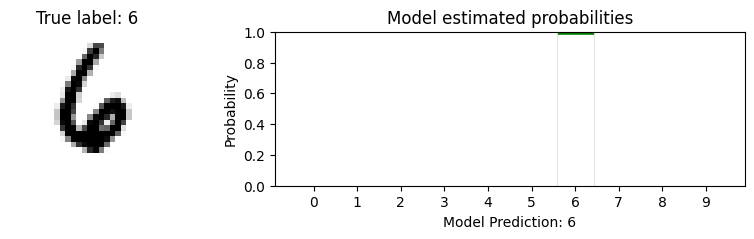

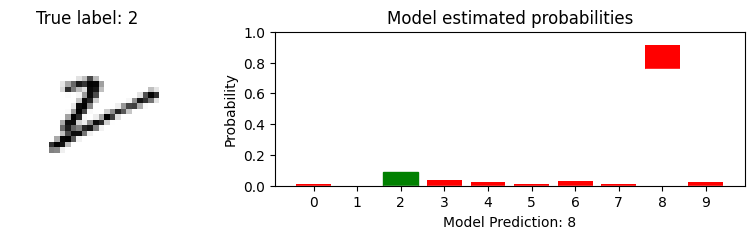

In [193]:
# Prediction examples on MNIST

for i in [0, 1577]:
    analyse_model_prediction_ensemble(x_test, y_test, ensemble_cnns, i)

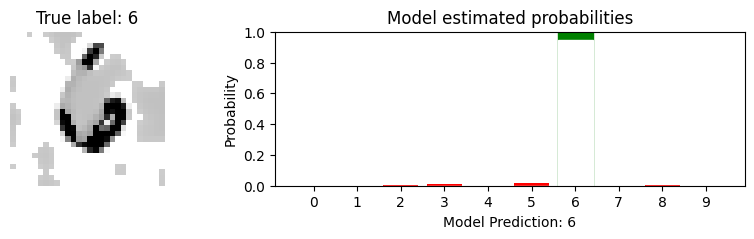

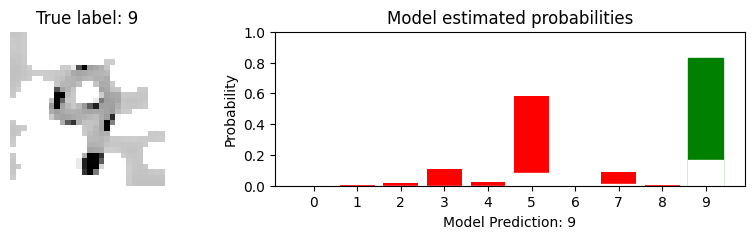

In [194]:
# Prediction examples on MNIST-C

for i in [0, 3710]:
    analyse_model_prediction_ensemble(x_c_test, y_c_test, ensemble_cnns, i)

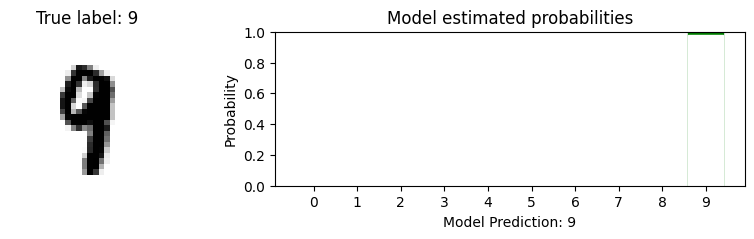

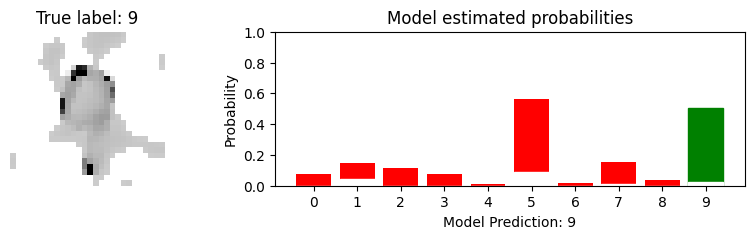

In [195]:
# Prediction examples from both datasets

for i in [9241]:
    analyse_model_prediction_ensemble(x_test, y_test, ensemble_cnns, i)
    analyse_model_prediction_ensemble(x_c_test, y_c_test, ensemble_cnns, i)

It's not surprising what's happening here: the spatters cover up most of the number. You would hope a model indicates that it's unsure here, since there's very little information to go by. This is exactly what's happened.

### Exercise 5:

Repeat Excercise 1 and Compare the output of the ensemble with the output of the single model

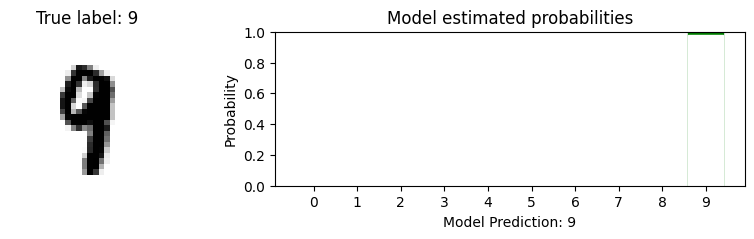

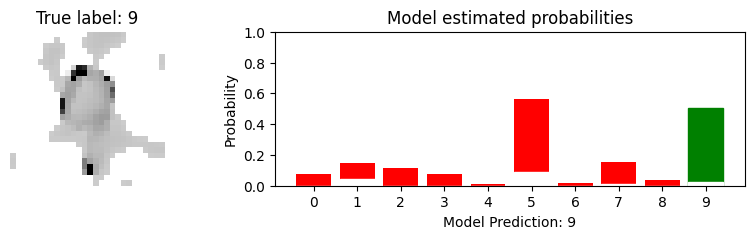

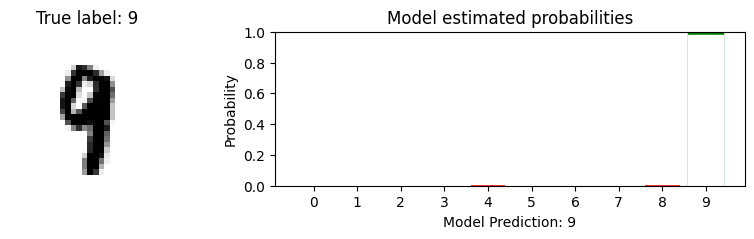

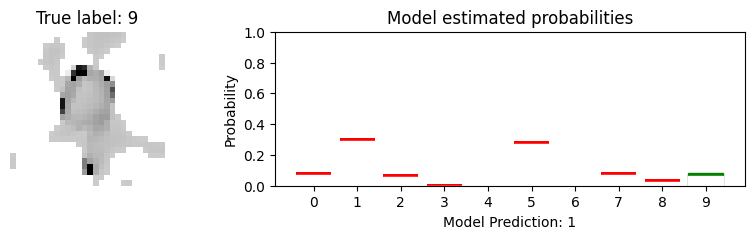

In [196]:
for i in [9241]:
    analyse_model_prediction_ensemble(x_test, y_test, ensemble_cnns, i)
    analyse_model_prediction_ensemble(x_c_test, y_c_test, ensemble_cnns, i)
    analyse_model_prediction(x_test, y_test, cnn_model, i)
    analyse_model_prediction(x_c_test, y_c_test, cnn_model, i)

## Uncertainty quantification using entropy


In [197]:
# Functions to plot the distribution of the information entropy across samples,
# split into whether the model prediction is correct or incorrect

def combine_ensemble(probabilistic_models, x):
    probs_ensemble = tf.stack([
                        probabilistic_models[i](x)
                        for i in range(len(probabilistic_models))
                    ])
    return tf.reduce_mean(probs_ensemble, axis=0)


def get_correct_indices_ensemble(probabilistic_models, x, labels):
    logits_valid = tf.stack([
                        tf.math.log(probabilistic_models[i](x))
                        for i in range(len(probabilistic_models))
                    ])
    logs = tf.nn.log_softmax(tf.math.reduce_logsumexp(logits_valid,axis=0))

    correct = np.argmax(logs, axis=1) == np.squeeze(labels)
    correct_indices = [i for i in range(x.shape[0]) if correct[i]]
    incorrect_indices = [i for i in range(x.shape[0]) if not correct[i]]
    return correct_indices, incorrect_indices

def plot_entropy_distribution_ensemble(probabilistic_models, x, labels):
    logits_valid = tf.stack([
                        tf.math.log(probabilistic_models[i](x))
                        for i in range(len(probabilistic_models))
                    ])
    logs = tf.nn.log_softmax(tf.math.reduce_logsumexp(logits_valid,axis=0))

    entropy = -tf.reduce_sum(tf.exp(logs)*logs,axis=1).numpy()
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    for i, category in zip(range(2), ['Correct', 'Incorrect']):
        entropy_category = entropy[get_correct_indices_ensemble(probabilistic_models, x, labels)[i]]
        mean_entropy = np.mean(entropy_category)
        num_samples = entropy_category.shape[0]
        title = category + 'ly labelled ({:.1f}% of total)'.format(num_samples / x.shape[0] * 100)
        axes[i].hist(entropy_category, weights=(1/num_samples)*np.ones(num_samples))
        axes[i].annotate('Mean: {:.3f} bits'.format(mean_entropy), (0.4, 0.9), ha='center')
        axes[i].set_xlabel('Entropy (bits)')
        axes[i].set_ylim([0, 1])
        axes[i].set_ylabel('Probability')
        axes[i].set_title(title)
    plt.show()

MNIST test set:


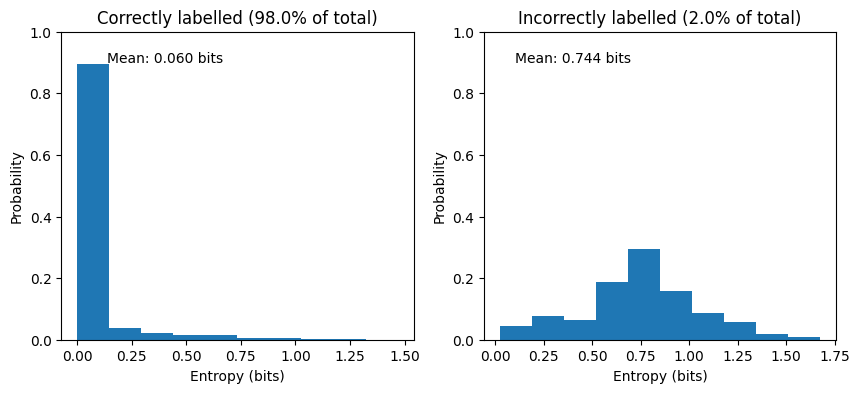

In [198]:
# Entropy plots for the MNIST dataset

print('MNIST test set:')
plot_entropy_distribution_ensemble(ensemble_cnns, x_test, y_test)

Corrupted MNIST test set:


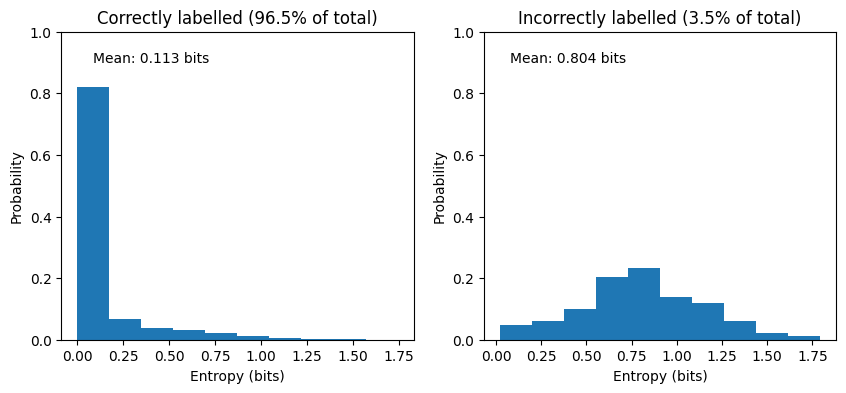

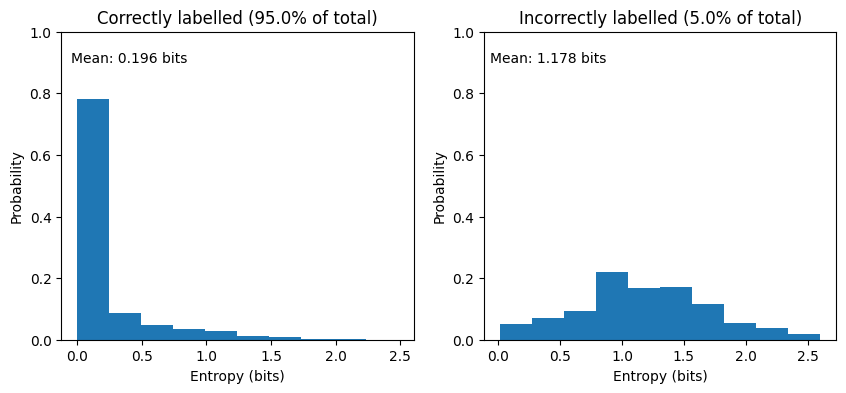

In [199]:
# Entropy plots for the MNIST-C dataset

print('Corrupted MNIST test set:')
plot_entropy_distribution_ensemble(ensemble_cnns, x_c_test, y_c_test)
plot_entropy_distribution(cnn_model, x_c_test, y_c_test)

### Exercise 6:

Compare the entropy of the ensemble with the entropy of an individual model analyzed in the previous section.

## Using a Ensemble of Probabilistic Models for Selective Predictions


In [200]:
#@title
def accuracy_by_threshold_ensemble(probabilistic_models, x, labels, threshold):
  probs=combine_ensemble(probabilistic_models, x).numpy()
  above_threshold = np.max(probs,axis=1)>threshold
  correct = np.argmax(probs, axis=1) == np.squeeze(labels)
  return threshold, 100*np.sum(np.logical_and(above_threshold, correct))/np.sum(above_threshold), 100*np.sum(above_threshold)/x.shape[0]

def plot_accuracy_by_threshold_ensemble(model, x, labels):
  values = np.array([accuracy_by_threshold_ensemble(model, x, labels, threshold) for threshold in np.arange(0.0,1,0.01)])
  fig, ax1 = plt.subplots()
  ax2 = ax1.twinx()
  ax1.plot(values[:,0],values[:,1], 'g-')
  ax2.plot(values[:,0],values[:,2], 'b-')

  ax1.set_xlabel('Decision Threshold')
  ax1.set_ylabel('Accuracy', color='g')
  ax2.set_ylabel('Coverage', color='b')

  plt.show()

  return np.mean(values[:,1]), np.mean(values[:,2])


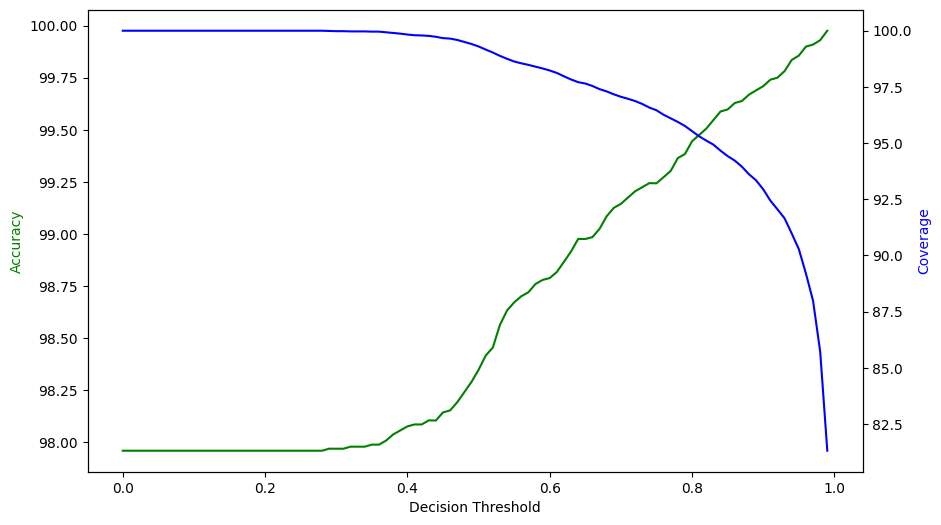

Area under Accuracy on MNIST test set:  98.62593857608354
Area under Coverage on MNIST test set:  97.6499


In [201]:
# MNIST:  Plot Accuracy / Coverage evolution for different thresholds
area_acc, area_coverage = plot_accuracy_by_threshold_ensemble(ensemble_cnns, x_test, y_test)
print('Area under Accuracy on MNIST test set: ',
      str(area_acc))
print('Area under Coverage on MNIST test set: ',
      str(area_coverage))

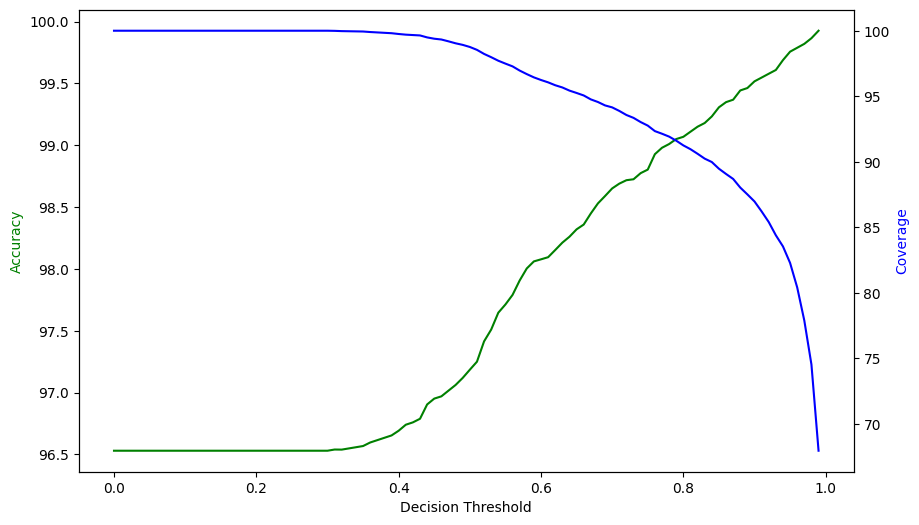

Area under Accuracy on corrupted MNIST test set:  97.68311118234197
Area under Coverage on corrupted MNIST test set:  95.5672


In [202]:
# MNIST-C:  Plot Accuracy / Coverage evolution for different thresholds
area_acc, area_coverage = plot_accuracy_by_threshold_ensemble(ensemble_cnns, x_c_test, y_c_test)
print('Area under Accuracy on corrupted MNIST test set: ',
      str(area_acc))
print('Area under Coverage on corrupted MNIST test set: ',
      str(area_coverage))

### Exercise 7:

Repeat Excercise 3 using this ensemble of neural networks and compare and discuss the results.


Use the function:

```python
_, accuracy, coverage = accuracy_by_threshold_ensemble(ensemble_cnns, input, labels, threshold):
```

In [205]:
def find_threshold_for_accuracy_emsemble(model, x, labels, target_accuracy=99.0):
    for threshold in np.arange(0.0, 1.0, 0.01):
        _, accuracy, coverage = accuracy_by_threshold_ensemble(model, x, labels, threshold)
        if accuracy >= target_accuracy:
            return threshold, accuracy, coverage
    return None, None, None

# Find threshold for MNIST dataset
mnist_threshold, mnist_accuracy, mnist_coverage = find_threshold_for_accuracy(cnn_model, x_test, y_test)
print(f"MNIST dataset: Threshold = {mnist_threshold}, Accuracy = {mnist_accuracy}%, Coverage = {mnist_coverage}%")

# Find threshold for Corrupted MNIST dataset
corrupted_mnist_threshold, corrupted_mnist_accuracy, corrupted_mnist_coverage = find_threshold_for_accuracy(cnn_model, x_c_test, y_c_test)
print(f"Corrupted MNIST dataset: Threshold = {corrupted_mnist_threshold}, Accuracy = {corrupted_mnist_accuracy}%, Coverage = {corrupted_mnist_coverage}%")


# Find threshold for MNIST dataset for EMsemble
Emnist_threshold, Emnist_accuracy, Emnist_coverage = find_threshold_for_accuracy_emsemble(ensemble_cnns, x_test, y_test)
print(f"EMMNIST dataset: Threshold = {Emnist_threshold}, Accuracy = {Emnist_accuracy}%, Coverage = {Emnist_coverage}%")

# Find threshold for Corrupted MNIST dataset for emsemble
Ecorrupted_mnist_threshold, Ecorrupted_mnist_accuracy, Ecorrupted_mnist_coverage = find_threshold_for_accuracy_emsemble(ensemble_cnns, x_c_test, y_c_test)
print(f"EMCorrupted MNIST dataset: Threshold = {Ecorrupted_mnist_threshold}, Accuracy = {Ecorrupted_mnist_accuracy}%, Coverage = {Ecorrupted_mnist_coverage}%")


MNIST dataset: Threshold = 0.7000000000000001, Accuracy = 99.03656894229773%, Coverage = 96.53%
Corrupted MNIST dataset: Threshold = 0.87, Accuracy = 99.06347554630594%, Coverage = 86.49%
EMMNIST dataset: Threshold = 0.67, Accuracy = 99.02464065708419%, Coverage = 97.4%
EMCorrupted MNIST dataset: Threshold = 0.78, Accuracy = 99.0100087032202%, Coverage = 91.92%


### Exercise 8: Impact of Ensemble Size on Performance Metrics

In this exercise, you will explore how increasing the number of models in an ensemble affects the outcomes of the tasks addressed in Exercises 5, 6, and 7. Previously, you worked with an ensemble consisting of only two models. Your goal is to investigate whether adding more models to the ensemble leads to improvements in the performance metrics evaluated in those exercises. Specifically, you will:

1. **Replicate Experiments**: Repeat the experiments from Exercises 5, 6, and 7, using ensembles with varying numbers of models (e.g., 3, 5, 10, etc.).
   
2. **Analyze Changes**: Assess how the performance metrics from Exercises 5, 6, and 7 change as the ensemble size increases.
   
3. **Identify Trends**: Determine whether there is a point of diminishing returns, where adding more models no longer provides significant improvements or leads to overfitting.

4. **Discuss Findings**: Summarize your findings, focusing on:
   - The relationship between ensemble size and performance.
   - Any trade-offs observed, such as increased computational cost or memory usage.
   - Implications for practical applications where ensemble size is a factor.

This exercise will help you understand how ensemble size influences the effectiveness of combined models and the associated computational trade-offs.